In [ ]:
from source import Dataset
from source import tools
import awkward as ak
import glob
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import eli5
from eli5.sklearn import PermutationImportance
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [2]:
#selecting features 
branches_to_use = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ", 
"cscRechitClusterSize",
"cscRechitCluster_match_gLLP_e"
]

#energy key
truth_value = "cscRechitCluster_match_gLLP_e"
size_value = "cscRechitClusterSize"

In [3]:
#read data
dataset_signal = Dataset.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_bigger_dataset.h5")

#cut clusters which don't have LLP
olen = len(df_signal)
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]
print('cut out ' + str(olen - len(df_signal)) + ' clusters, which leaves ' + str(len(df_signal)) + ' clusters containing a LLP decay for training')

Opening file  /nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_bigger_dataset.h5
cut out 10236 clusters, which leaves 344078 clusters containing a LLP decay for training


In [4]:
# select correct columns
df_signal = df_signal[branches_to_use]

# Scaler should be applied here
scaler = StandardScaler()
scaler = scaler.fit(df_signal)
df_signal_cc = scaler.transform(df_signal)
#df_signal_cc = df_signal[branches_to_use].to_numpy()

# Splitting the data into train, val, test
train_data, testval_data = train_test_split(df_signal_cc, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

# assigning labels (true energy values)
train_labels = np.array(train_data[:,25])#([1.]*len(train_data))
test_labels = np.array(test_data[:,25])#([1.]*len(test_data))
val_labels = np.array(val_data[:,25])#([1.]*len(val_data))

train_sizes = train_data[:,24]

# select only branches we want
train_data = train_data[:,:25]
test_data = test_data[:,:25]
val_data = val_data[:,:25]

# check the shape
print(" signal training features", train_data.shape,
    "\n signal training labels", train_labels.shape,
    "\n signal test features", test_data.shape,
    "\n ignal test labels", test_labels.shape,
    "\n signal val features", val_data.shape,
    "\n signal val labels", val_labels.shape)
print(df_signal.shape, df_signal_cc.shape)

# store number of features for input shape
n_features = train_data.shape[1]

 signal training features (206446, 25) 
 signal training labels (206446,) 
 signal test features (68816, 25) 
 ignal test labels (68816,) 
 signal val features (68816, 25) 
 signal val labels (68816,)
(344078, 26) (344078, 26)


Text(0.5, 0, 'energy')

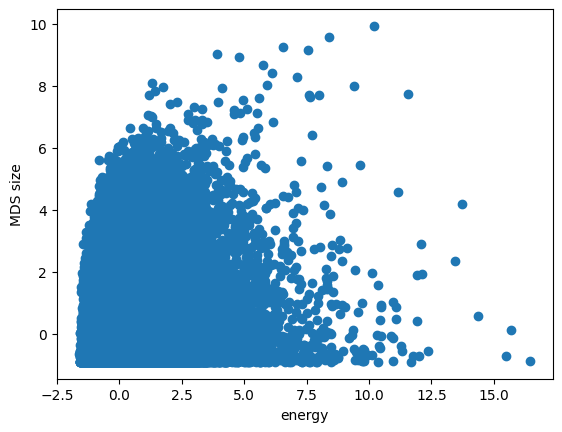

In [5]:
# inspect energy vs size distribution
plt.scatter(train_labels, train_sizes)
plt.ylabel('MDS size')
plt.xlabel('energy')
#plt.xlim(0, 1300)
#plt.ylim(0, 2000)

In [6]:
# prerequesites

X_train, Y_train = sklearn.utils.shuffle(train_data, train_labels, random_state=0) # change to random_state=None for full randomness
X_test, Y_test = sklearn.utils.shuffle(test_data, test_labels, random_state=0) # change to random_state=None for full randomness
X_val, Y_val = sklearn.utils.shuffle(val_data, val_labels, random_state=0) # change to random_state=None for full randomness

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 10,
    mode = 'min',#max
    restore_best_weights = True)

METRICS = [keras.metrics.MeanSquaredError(name='Brier score'),]

testing_df = pd.DataFrame({'layers': [], 'LOFeatures': [],'epochs': [],'batchsize': [], 'learnrate': [], 'train_loss': [], 'val_loss': [], 'test_loss': [], 'history': []})
print(testing_df)

Empty DataFrame
Columns: [layers, LOFeatures, epochs, batchsize, learnrate, train_loss, val_loss, test_loss, history]
Index: []


In [7]:
# Define Functions
def make_model(metrics=METRICS, output_bias=None, layers = [50, 30, 20, 5, 1], n_input = n_features, learningrate = 1e-3):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    #initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=200, seed=None)
    initializer = tf.keras.initializers.Constant(value=100)
    
    model = keras.Sequential(keras.layers.Dense(layers[0], use_bias = True, activation = 'leaky_relu', input_shape = (n_input,)))

    
    for nodes in layers[1:]:
        model.add(keras.layers.Dense(nodes, use_bias = True, activation = 'leaky_relu'))
    

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learningrate),
        loss = keras.losses.MeanSquaredError(name='MSE'),
        metrics = metrics
    )
    
    return model

def plot_loss(history):
    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(history.epoch, history.history['loss'], label = 'Training', color = 'blue')
    ax.plot(history.epoch, history.history['val_loss'], linestyle = '--', color = 'blue', label = 'Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.legend()
    
def predict_plot(model, test_data, test_labels, batches, title = None, axlabels = ('clusters', 'generated particle energy')):
    fig, ax = plt.subplots(figsize = (6, 4))
    
    predictions = model.predict(test_data, batch_size = batches,  verbose=0)
    histdata, bins, dummy = ax.hist(test_labels, bins = 50, histtype="step", color = 'b', label = 'truth')
    ax.hist(predictions, bins = bins, histtype="step", color = 'r', label = 'predictions')
    ax.set_yscale('log')
    ax.set_ylabel(axlabels[0])
    ax.set_xlabel(axlabels[1])
    ax.legend()
    if title:
        ax.set_title(title)

        
def modeltest(plotdatax, plotdatay, x = [X_train, X_val, X_test], y = [Y_train, Y_val, Y_test], layers = [50, 30, 20, 5, 1], leftoutfeatures = [], epochs = 100, learn = 1e-3, batchsize = 1024, storage = testing_df):
    print('model layers : ', layers, 
         '\nfeatures left out : ', leftoutfeatures,
         '\nepochs : ', epochs,
         '\nbatch size : ', batchsize,
         '\nlearning rate : ', learn)
    
    if leftoutfeatures:
        x[0] = x[0].drop(leftoutfeatures, axis = 1)
        x[1] = x[1].drop(leftoutfeatures, axis = 1)
        x[2] = x[2].drop(leftoutfeatures, axis = 1)
            
    mymodel = make_model(layers = layers, learningrate = learn, n_input = n_features - len(leftoutfeatures))
    #mymodel.summary()
    history = mymodel.fit(
    x[0],
    y[0],
    batch_size = batchsize,
    epochs = epochs, 
    callbacks = [early_stopping],
    validation_data = (x[1], y[1]),
    verbose = 0)
    
    results = mymodel.evaluate(x[0], y[0], batch_size = batchsize, verbose=0)
    print("Loss on training: {:0.4f}".format(results[0]))
    
    results_val = mymodel.evaluate(x[1], y[1], batch_size = batchsize, verbose=0)
    print("Loss on validation: {:0.4f}".format(results_val[0]))
    
    results_test = mymodel.evaluate(x[2], y[2], batch_size = batchsize, verbose=0)
    print("Loss on test: {:0.4f}".format(results_test[0]))
    print("-----------------")
    
    ep = early_stopping.stopped_epoch
    if ep == 0:
        ep = epochs
        
    new_row = {'layers': layers, 'LOFeatures': leftoutfeatures, 'epochs': ep, 'batchsize': batchsize, 'learnrate': learn, 'train_loss': results[0], 'val_loss': results_val[0], 'test_loss': results_test[0], 'history': history}
    storage.loc[len(storage)] = new_row

    
    plot_loss(history)
    predict_plot(model = mymodel,  test_data = x[2], test_labels = y[2], title = 'predictions on test data', batches = batchsize)
    predict_plot(model = mymodel, test_data = x[0], test_labels = y[0], title = 'predictions on training data', batches = batchsize)
    

In [12]:
# Permutation Importance
estimator = KerasRegressor(build_fn=make_model, epochs=100, batch_size=2048, validation_split=0.1, verbose=1, shuffle=True)
history = estimator.fit(X_train, Y_train, callbacks = [early_stopping])

perm = PermutationImportance(estimator, random_state=1).fit(X_test, Y_test)

Epoch 1/100


/nfs/dust/cms/user/loewetob/anaconda3/envs/mds_regression/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


91/91 [==============================] - 1s 6ms/step - loss: 0.7460 - Brier score: 986110912.0000 - val_loss: 0.6623 - val_Brier score: 0.6623
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6676 - Brier score: 0.6676 - val_loss: 0.6416 - val_Brier score: 0.6416
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6542 - Brier score: 0.6542 - val_loss: 0.6331 - val_Brier score: 0.6331
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6464 - Brier score: 0.6464 - val_loss: 0.6303 - val_Brier score: 0.6303
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6407 - Brier score: 0.6407 - val_loss: 0.6257 - val_Brier score: 0.6257
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6356 - Brier score: 0.6356 - val_loss: 0.6208 - val_Brier score: 0.6208
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6308 - Brier score: 0.6308 - val_loss: 0.6160 -

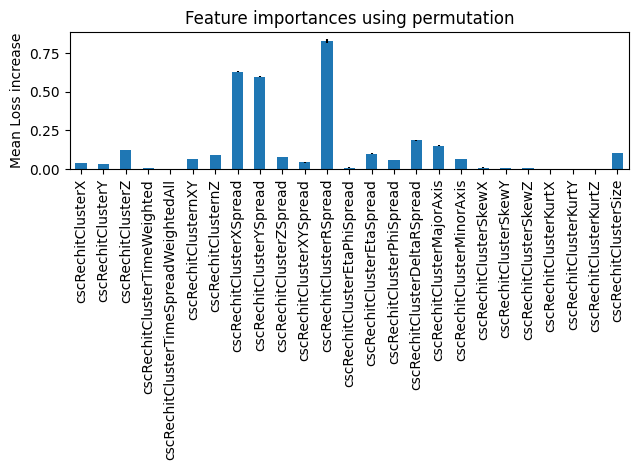

In [17]:
forest_importances = pd.Series(perm.feature_importances_, index = branches_to_use[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = perm.feature_importances_std_, ax = ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean Loss increase")
fig.tight_layout()
plt.show()

model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.01
Loss on training: 0.5677
Loss on validation: 0.5803
Loss on test: 0.6042
-----------------


/nfs/dust/cms/user/loewetob/anaconda3/envs/mds_regression/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


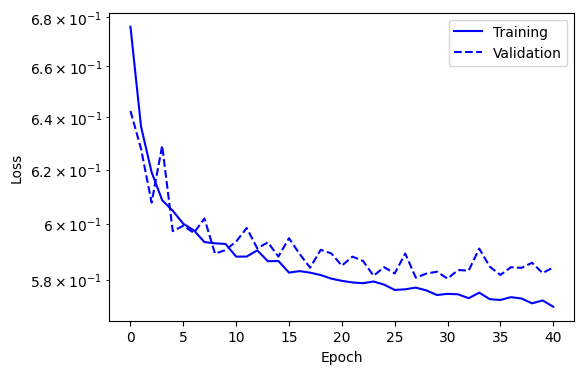

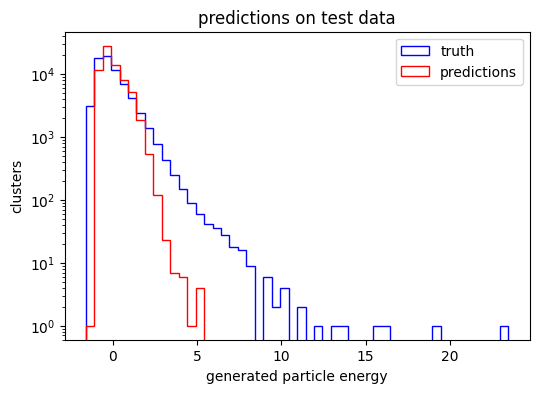

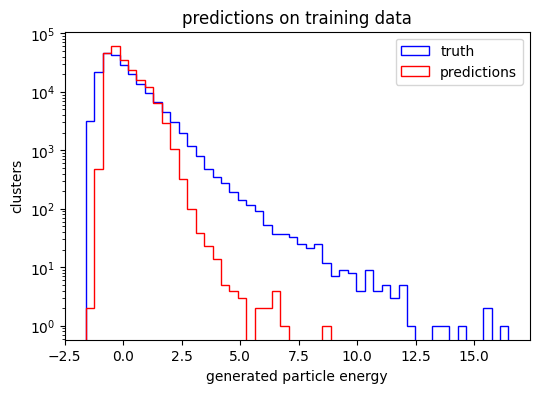

In [8]:
modeltest(plotdatax = test_data, plotdatay = test_labels, leftoutfeatures = [], learn = 0.01, batchsize = 2048)

In [ ]:
#test different batch sizes
batch_df = pd.DataFrame({'layers': [], 'LOFeatures': [],'epochs': [],'batchsize': [], 'learnrate': [], 'train_loss': [], 'val_loss': [], 'test_loss': [], 'history': []})
size = 32
while size < 35000:
    for i in range(5):
        modeltest(plotdatax = test_data, plotdatay = test_labels, layers = [50, 30, 20, 5, 1], learn = 0.01, batchsize = size, storage = batch_df)
    size = size * 2

model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  32 
learning rate :  0.01


In [ ]:
print(len(batch_df))
batch_df_corr = batch_df[batch_df['train_loss'] < 12000]
print(len(batch_df_corr))

siz = 32
sizes = []
while siz < 35000:
    sizes.append(siz)
    siz *= 2
print(sizes)


In [ ]:
tlossarr = []
vlossarr = []
telossarr = []

for size in sizes:
    tlossarr.append(pd.array(batch_df_corr[batch_df_corr['batchsize'] == size]['train_loss']))
    vlossarr.append(pd.array(batch_df_corr[batch_df_corr['batchsize'] == size]['val_loss']))
    telossarr.append(pd.array(batch_df_corr[batch_df_corr['batchsize'] == size]['test_loss']))
    
tlosses_m = []
vlosses_m = []
telosses_m = []
tlosses_std = []
vlosses_std = []
telosses_std = []

for t in tlossarr:
    tlosses_m.append(np.mean(np.array(t)))
    tlosses_std.append(np.std(np.array(t)))
for v in vlossarr:
    vlosses_m.append(np.mean(np.array(v)))
    vlosses_std.append(np.std(np.array(v)))
for te in telossarr:
    telosses_m.append(np.mean(np.array(te)))
    telosses_std.append(np.std(np.array(te)))
    

fig, ax = plt.subplots()

ax.scatter(sizes, tlosses_m, s = 10, label = 'training')
ax.errorbar(sizes, tlosses_m, yerr = tlosses_std, ls = 'None', capsize = 3)
ax.scatter(sizes, vlosses_m, s = 10, label = 'val')
ax.errorbar(sizes, vlosses_m, yerr = vlosses_std, ls = 'None', capsize = 3)
ax.scatter(sizes, telosses_m, s = 10, label = 'test')
ax.errorbar(sizes, telosses_m, yerr = telosses_std, ls = 'None', capsize = 3)
ax.set_xscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('batch size')
ax.set_ylim(4200, 5200)
ax.set_title('testing different batch sizes')
ax.legend()

In [ ]:
for i in range(3):
    modeltest(plotdatax = test_data, plotdatay = test_labels, layers = [50, 30, 20, 5, 1], learn = 0.1, batchsize = 2048)

In [28]:
testing_df

,layers,LOFeatures,epochs,batchsize,learnrate,train_loss,val_loss,test_loss,history
0,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,5032.368164,5132.223633,5060.971191,<keras.callbacks.History object at 0x2b9884a13...
1,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4995.772949,5091.758789,5026.850098,<keras.callbacks.History object at 0x2b9884b2a...
2,"[50, 30, 20, 5, 1]",[],10.0,2048.0,0.0001,33981.347656,34084.917969,33971.273438,<keras.callbacks.History object at 0x2b9727fc0...
3,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4926.991699,5030.626465,4962.275391,<keras.callbacks.History object at 0x2b9884bec...
4,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4967.271973,5073.384277,4978.645508,<keras.callbacks.History object at 0x2b9884c96...
...,...,...,...,...,...,...,...,...,...
70,"[50, 30, 20, 5, 1]",[],66.0,2048.0,0.1000,4643.258301,4758.076172,4669.034180,<keras.callbacks.History object at 0x2b99a0ba5...
71,"[50, 30, 20, 5, 1]",[],54.0,2048.0,0.1000,4691.696289,4800.372070,4730.669922,<keras.callbacks.History object at 0x2b99a0c16...
72,"[50, 30, 20, 5, 1]",[],74.0,2048.0,0.1000,4678.736328,4782.205078,4698.897461,<keras.callbacks.History object at 0x2b9c0a475...
73,"[50, 30, 20, 5, 1]",[],30.0,2048.0,0.1000,4894.336914,4991.839844,4908.638672,<keras.callbacks.History object at 0x2b99a1a32...


model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.01
Loss on training: 4513.3311
Loss on validation: 4486.6392
Loss on test: 4630.3950
-----------------


/nfs/dust/cms/user/loewetob/anaconda3/envs/mds_regression/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


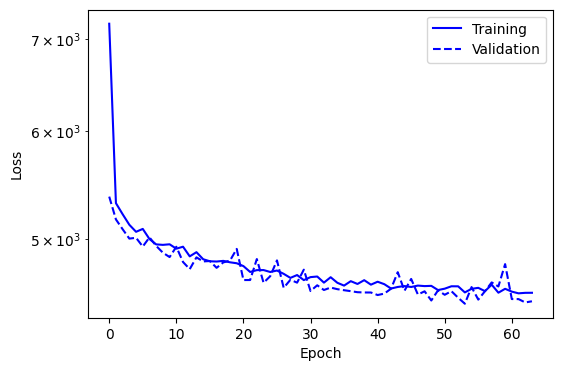

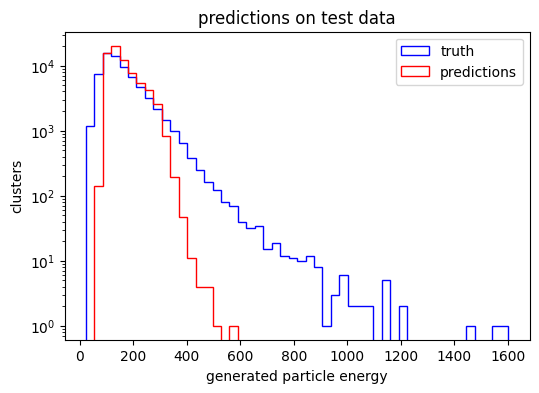

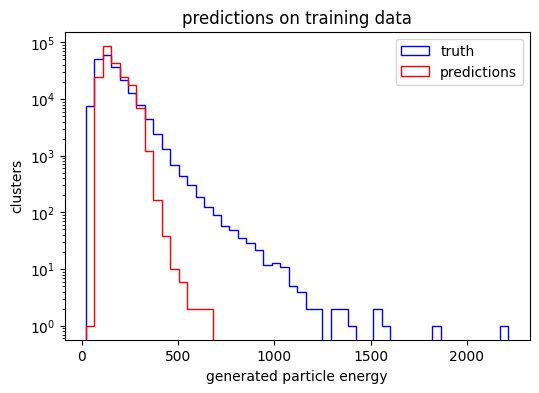

In [59]:
modeltest(plotdatax = test_data, plotdatay = test_labels, layers = [50, 30, 20, 5, 1], learn = 0.01, batchsize = 2048, storage = testing_df)

In [29]:
testing_df_corr = testing_df[testing_df['train_loss'] <= 25000]

In [15]:
#test different learning rates
lrates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for lrate in lrates:
    for i in range(10):
        modeltest(plotdatax = test_data, plotdatay = test_labels, layers = [50, 30, 20, 5, 1], learn = lrate, batchsize = 2048)

model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001
Loss on training: 5032.3682
Loss on validation: 5132.2236
Loss on test: 5060.9712
-----------------
model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001


/nfs/dust/cms/user/loewetob/anaconda3/envs/mds_regression/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


Loss on training: 4995.7729
Loss on validation: 5091.7588
Loss on test: 5026.8501
-----------------
model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Loss on training: 33981.3477
Loss on validation: 34084.9180
Loss on test: 33971.2734
-----------------
model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001
Loss on training: 4926.9917
Loss on validation: 5030.6265
Loss on test: 4962.2754
-----------------
model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001
Loss on training: 4967.2720
Loss on validation: 5073.3843
Loss on test: 4978.6455
-----------------
model layers :  [50, 30, 20, 5, 1] 
features left out :  [] 
epochs :  100 
batch size :  2048 
learning rate :  0.0001
Loss on training: 4997.0610
Loss 

In [30]:
testing_df_corr

,layers,LOFeatures,epochs,batchsize,learnrate,train_loss,val_loss,test_loss,history
0,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,5032.368164,5132.223633,5060.971191,<keras.callbacks.History object at 0x2b9884a13...
1,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4995.772949,5091.758789,5026.850098,<keras.callbacks.History object at 0x2b9884b2a...
3,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4926.991699,5030.626465,4962.275391,<keras.callbacks.History object at 0x2b9884bec...
4,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4967.271973,5073.384277,4978.645508,<keras.callbacks.History object at 0x2b9884c96...
5,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4997.061035,5099.401855,5025.833496,<keras.callbacks.History object at 0x2b9884d13...
6,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4986.794434,5085.669434,5014.717285,<keras.callbacks.History object at 0x2b9884dde...
7,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,5028.354980,5132.493164,5063.478027,<keras.callbacks.History object at 0x2b9a23e51...
8,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4990.521973,5093.347168,5014.350586,<keras.callbacks.History object at 0x2b9884eed...
9,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0001,4984.878418,5097.019531,5020.221191,<keras.callbacks.History object at 0x2b9884fb3...
11,"[50, 30, 20, 5, 1]",[],100.0,2048.0,0.0005,4692.200195,4849.665527,4767.549805,<keras.callbacks.History object at 0x2b988501b...


In [68]:
rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
tlossarr = []
vlossarr = []
telossarr = []

for rate in rates:  
    tlossarr.append(pd.array(testing_df_corr[testing_df_corr['learnrate'] == rate]['train_loss']))
    vlossarr.append(pd.array(testing_df_corr[testing_df_corr['learnrate'] == rate]['val_loss']))
    telossarr.append(pd.array(testing_df_corr[testing_df_corr['learnrate'] == rate]['test_loss']))

tlosses_m = []
vlosses_m = []
telosses_m = []
tlosses_std = []
vlosses_std = []
telosses_std = []

for t in tlossarr:
    tlosses_m.append(np.mean(np.array(t)))
    tlosses_std.append(np.std(np.array(t)))
for v in vlossarr:
    vlosses_m.append(np.mean(np.array(v)))
    vlosses_std.append(np.std(np.array(v)))
for te in telossarr:
    telosses_m.append(np.mean(np.array(te)))
    telosses_std.append(np.std(np.array(te)))
    


NameError: name 'testing_df_corr' is not defined

In [58]:
vlosses_m

[5092.880479600694,
 4811.829659598215,
 4721.12353515625,
 4648.211242675781,
 4673.537380642361,
 4721.229437934027,
 4821.196010044643]

NameError: name 'rates' is not defined

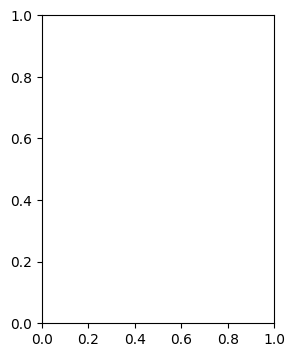

In [8]:
"""
lrates = []
tlosses = []
vlosses = []
telosses = []

for i in testing_df.index:
    lrates.append(testing_df['learnrate'][i])
    tlosses.append(testing_df['train_loss'][i])
    vlosses.append(testing_df['val_loss'][i])
    telosses.append(testing_df['test_loss'][i])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax.scatter(lrates, tlosses, label = 'training')
ax.scatter(lrates, vlosses, label = 'val')
ax.scatter(lrates, telosses, label = 'test')
ax.set_xscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('learning rate')
ax.set_ylim(4000, 5500)
ax.set_title('testing different learning rates')
ax.legend()
"""

fig, ax = plt.subplots(figsize = (3,4))

ax.scatter(rates, tlosses_m, s = 10, label = 'training')
ax.errorbar(rates, tlosses_m, yerr = tlosses_std, ls = 'None', capsize = 3)
ax.scatter(rates, vlosses_m, s = 10, label = 'val')
ax.errorbar(rates, vlosses_m, yerr = vlosses_std, ls = 'None', capsize = 3)
ax.scatter(rates, telosses_m, s = 10, label = 'test')
ax.errorbar(rates, telosses_m, yerr = telosses_std, ls = 'None', capsize = 3)
ax.set_xscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('learning rate')
ax.set_ylim(4000, 5500)
ax.set_title('testing different learning rates')
ax.legend()

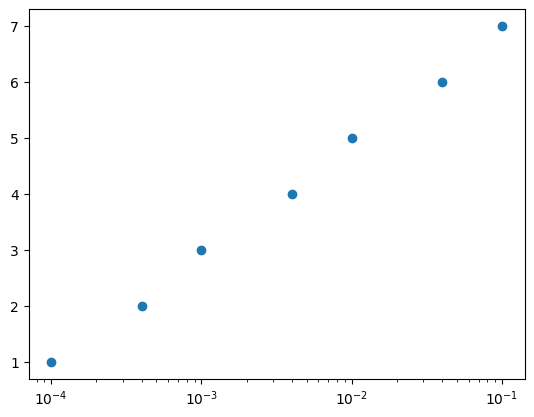

In [30]:
plt.scatter(a, b)
plt.xscale('log')

In [ ]:
erro = np.ones(12)*0.1
plt.plot(amps, xstd, '.')

plt.errorbar(amps, xstd, yerr=erro, capsize = 2)

In [75]:
a = pd.DataFrame({'A': [1,2,3], 'B': [4,5,6], 'C': [7,8,9]})
print(a)

   A  B  C
0  1  4  7
1  2  5  8
2  3  6  9


In [76]:
ff = a.to_numpy()

In [83]:
ff[:,:2]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [84]:
ff[:,2]

array([7, 8, 9])

In [9]:
a = [1,2,3,4,5,6,7,8,9,0]

In [10]:
a[:-3]

[1, 2, 3, 4, 5, 6, 7]